Based on following:

https://www.tensorflow.org/tutorials/load_data/images


https://www.tensorflow.org/tutorials/keras/basic_classification





In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.enable_eager_execution()
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

# TensorFlow and tf.keras

from tensorflow import keras

from google.colab import drive



# This will prompt for authorization.
drive.mount('/content/drive')

1.15.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data


In [0]:
# DEFINE CONSTANTS
data_root_path = "/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/"
project_id = "holzerkennung"
model_id = "ICN8825180478536945284"
service_account_file = '/content/drive/My Drive/Colab Notebooks/holzerkennung.json'

In [3]:
# IMPORT FILES AND LABELS
import pathlib
data_root = pathlib.Path(data_root_path)
print(data_root)

/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06


In [4]:
for item in data_root.iterdir():
  print(item)

/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links
/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/rechts


In [0]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

In [6]:
all_image_paths[:10]

['/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-081927-786939.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082041-787690.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082040-191708.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082046-247850.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-081931-999432.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-081933-759773.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082049-361521.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082044-545349.jpg',
 '/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-081929-399546.jpg',
 '/content/drive/My Drive/Co


# Inspect the images. Now let's have a quick look at a couple of the images, so you know what you're dealing with:

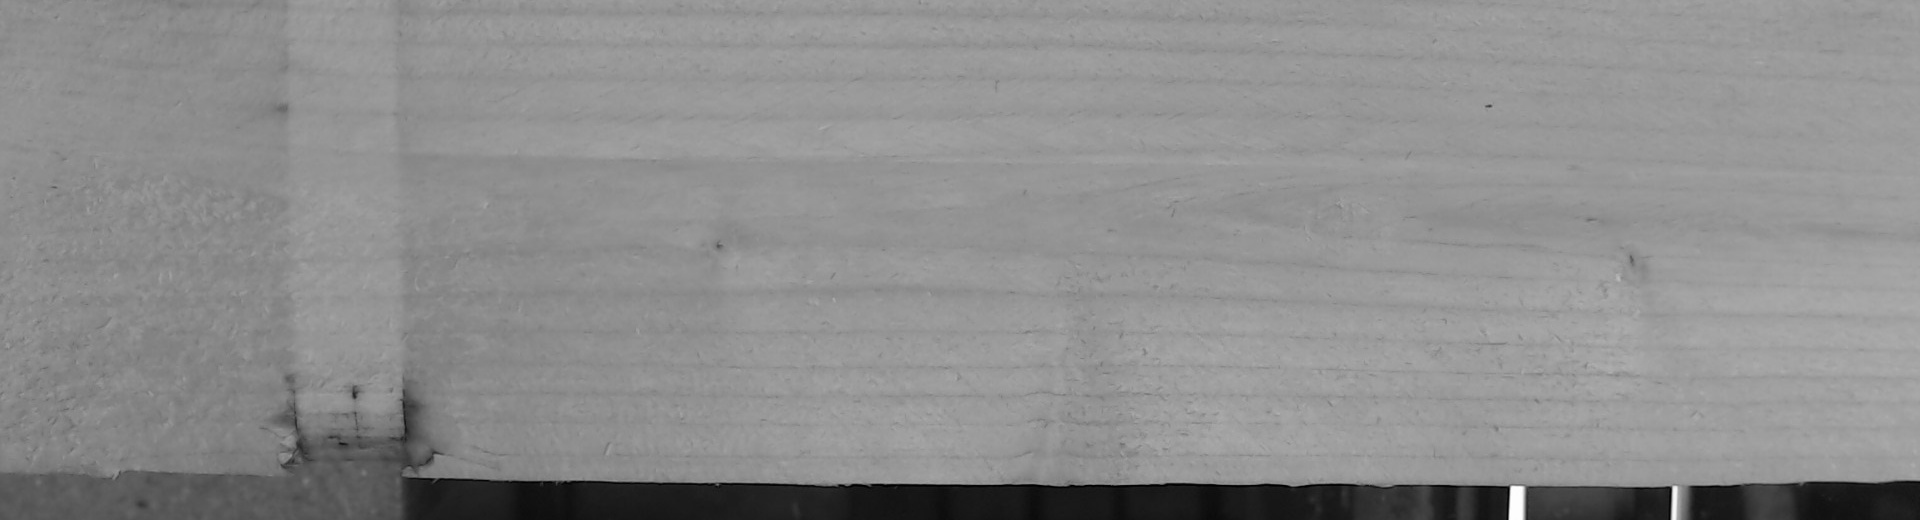

/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/rechts/20191106-083603-064582.jpg



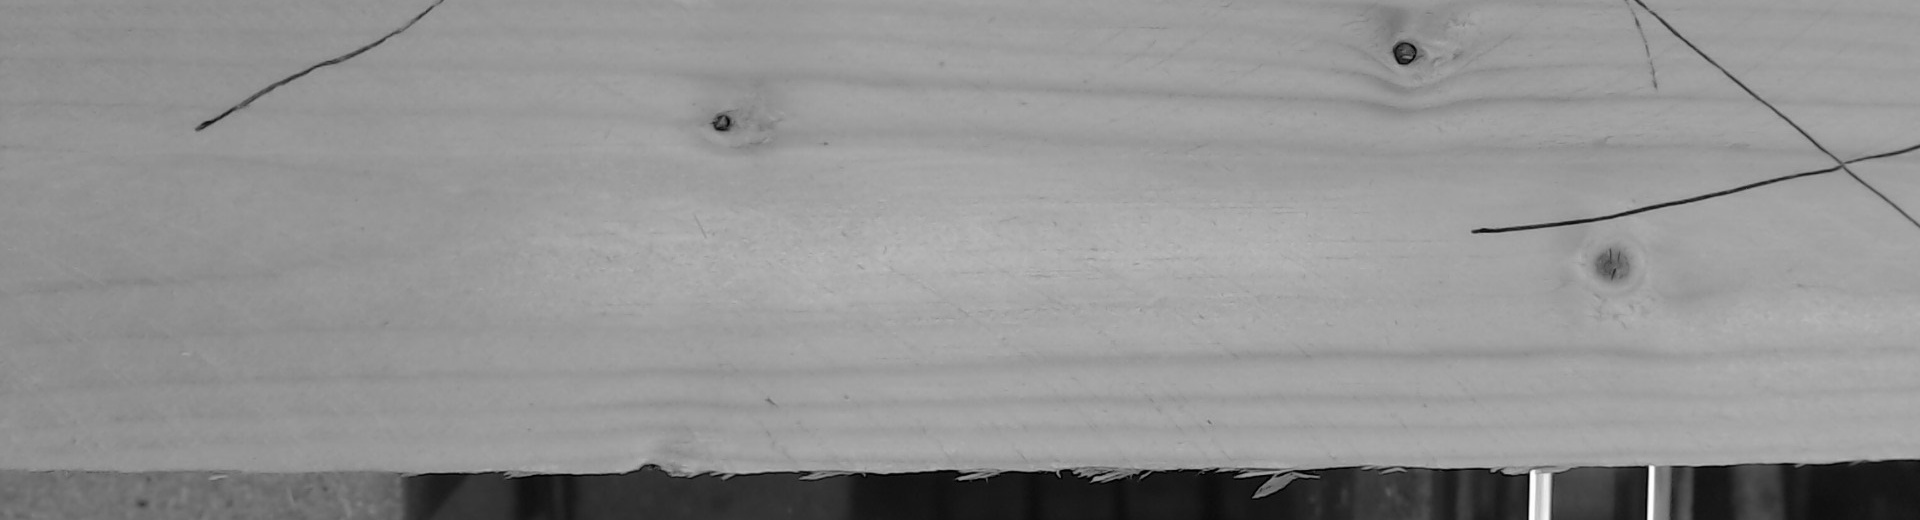

/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082348-556087.jpg



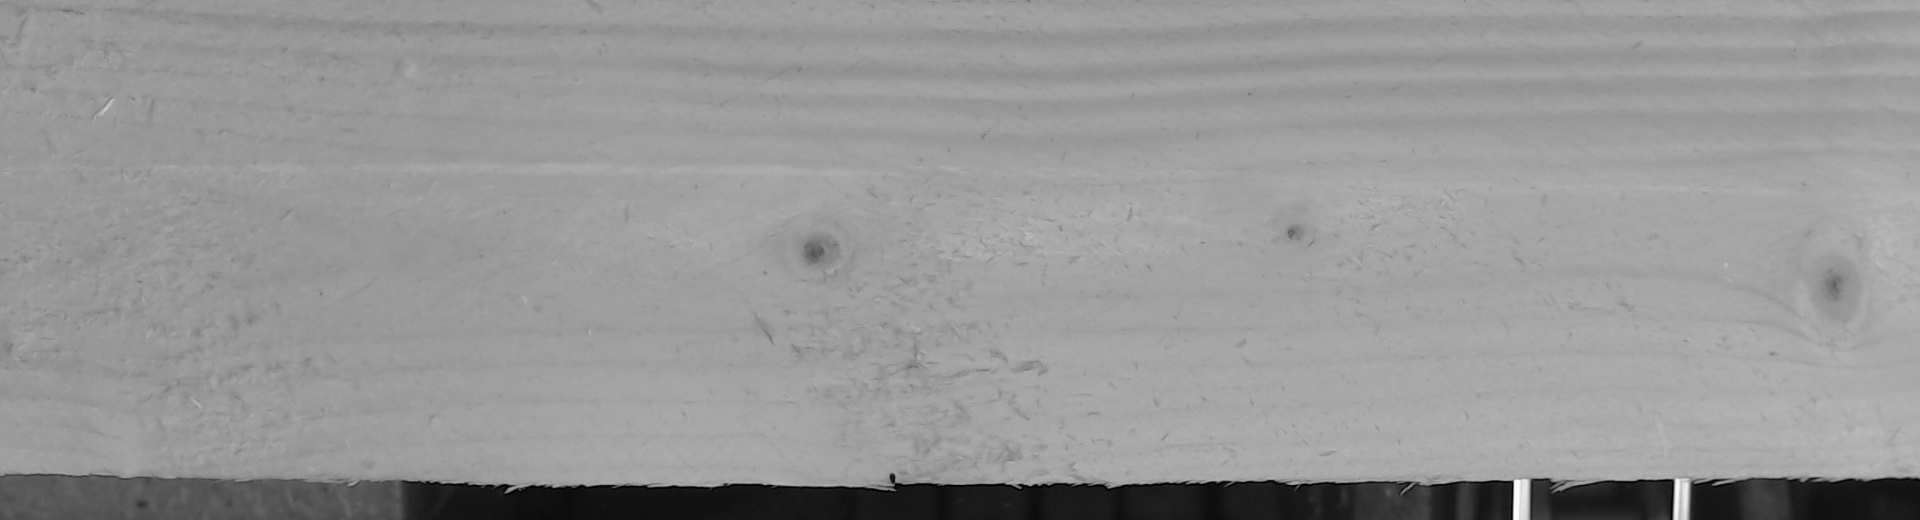

/content/drive/My Drive/Colab Notebooks/Images/ML_Boardflip_2019_11_06/links/20191106-082354-872705.jpg



In [7]:
import IPython.display as display
import os
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(image_path)
  print()


# Determine the label for each image
## List the available labels:

In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['links', 'rechts']

Assign an index to each label:

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'links': 0, 'rechts': 1}

Create a list of every file, and its label index

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

In [11]:
!pip install google-cloud-automl

     |████████████████████████████████| 307kB 3.5MB/s 


In [12]:
import sys

from google.cloud import automl_v1beta1
from google.cloud.automl_v1beta1.proto import service_pb2
from google.cloud.automl_v1beta1 import PredictionServiceClient
import json

!export GOOGLE_APPLICATION_CREDENTIALS="/content/drive/My Drive/Colab Notebooks/holzerkennung.json"

def get_prediction(content, project_id, model_id):
  prediction_client = PredictionServiceClient.from_service_account_file(service_account_file)
  
  name = 'projects/{}/locations/us-central1/models/{}'.format(project_id, model_id)
  payload = {'image': {'image_bytes': content }}
  params = {}
  request = prediction_client.predict(name, payload, params)
  return request  # waits till request is returned

def check_prediction(result, true_label):
  pred = result.payload[0].display_name
  return pred == true_label



number_of_items = len(all_image_paths)
counter = 0;

# iterate over all items
for i in range(0, number_of_items - 1):
  with open(all_image_paths[i], 'rb') as ff:
    content = ff.read()
    result = get_prediction(content, project_id,  model_id)
    if str(result)=="":
      print("Error processing file: ", all_image_paths[i])
      continue
    
    is_true = check_prediction(result, label_names[all_image_labels[i]]);
    print(i, result.payload[0].classification)
    if is_true == 0:
      counter = counter + 1
      # show image
      image_path = all_image_paths[i]
      display.display(display.Image(image_path))
      print(image_path)
      print(result)
        
performance = (number_of_items - counter) / number_of_items
print("Test Performance: ", performance)
    

  

Output hidden; open in https://colab.research.google.com to view.